# Face Recognition - Data Preparation and PCA
This notebook covers loading the ORL face dataset, preparing the data matrix and label vector, and performing PCA using scikit-learn.

In [1]:
import os
import numpy as np
import cv2
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Constants
IMAGE_WIDTH = 92
IMAGE_HEIGHT = 112
DATASET_PATH = './data/'  # Change this to your actual dataset path

def load_images_and_labels(dataset_path):
    data = []
    labels = []
    for subject_id in range(1, 41):
        subject_path = os.path.join(dataset_path, f's{subject_id}')
        for img_name in os.listdir(subject_path):
            img_path = os.path.join(subject_path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img_flat = img.flatten()
            data.append(img_flat)
            labels.append(subject_id)
    return np.array(data), np.array(labels)

# Load images and labels
X, y = load_images_and_labels(DATASET_PATH)
print(f'Data shape: {X.shape}, Labels shape: {y.shape}')


Data shape: (400, 10304), Labels shape: (400,)


In [2]:
# Split into training and testing
X_train = X[::2]
y_train = y[::2]
X_test = X[1::2]
y_test = y[1::2]

print(f'Train shape: {X_train.shape}, Test shape: {X_test.shape}')

Train shape: (200, 10304), Test shape: (200, 10304)


Alpha: 0.8, Components retained: 36


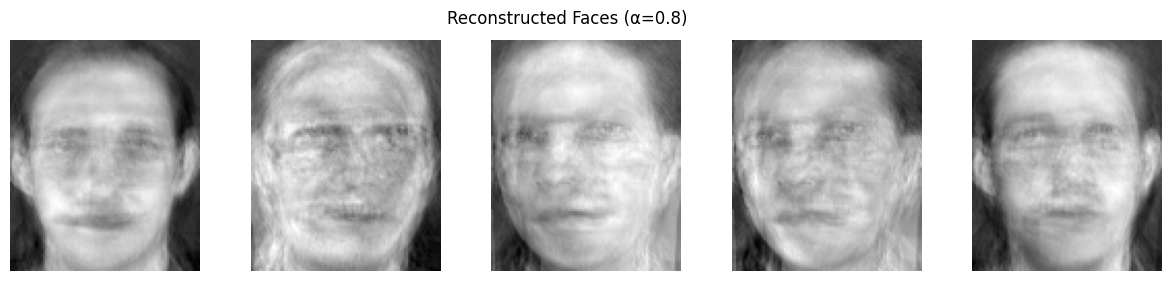

Alpha: 0.85, Components retained: 52


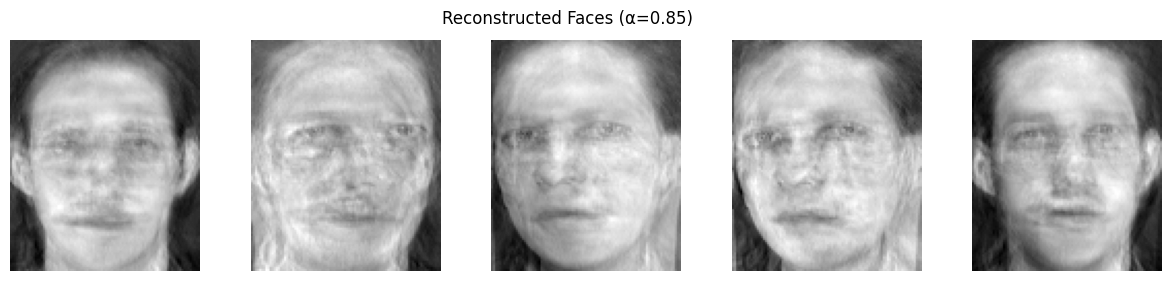

Alpha: 0.9, Components retained: 76


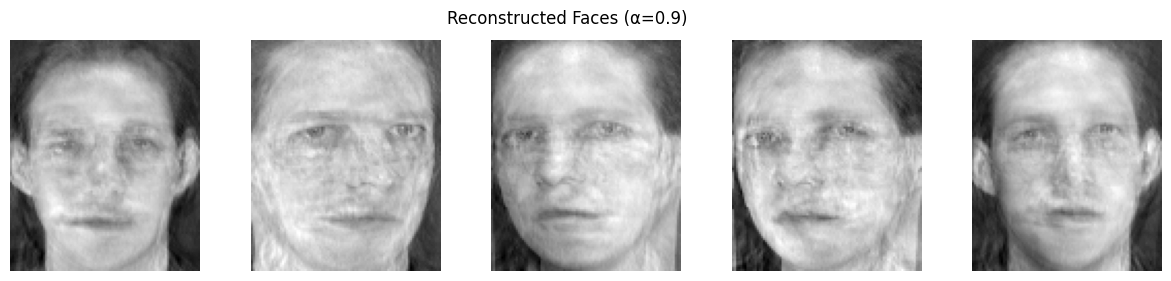

Alpha: 0.95, Components retained: 115


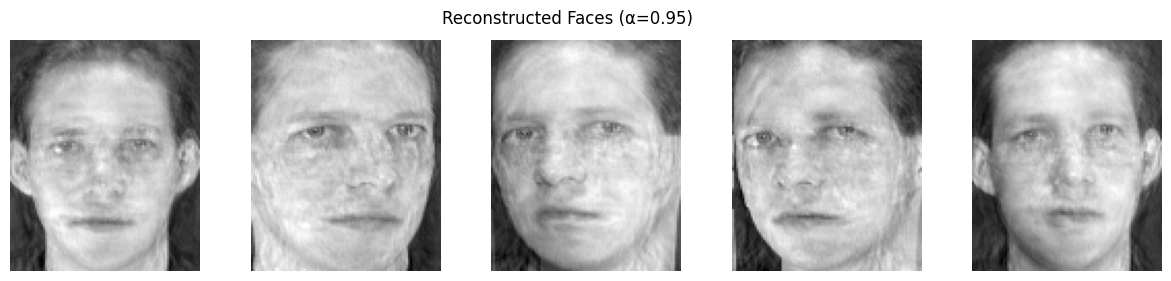

In [3]:
# PCA with variance retention
alphas = [0.8, 0.85, 0.9, 0.95]
pca_results = {}

for alpha in alphas:
    pca = PCA(n_components=alpha, svd_solver='full')
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    
    print(f'Alpha: {alpha}, Components retained: {pca.n_components_}')
    pca_results[alpha] = {
        'pca': pca,
        'X_train_pca': X_train_pca,
        'X_test_pca': X_test_pca,
    }

    # Visualize a few reconstructed faces
    reconstructed = pca.inverse_transform(X_train_pca[:5])
    fig, axs = plt.subplots(1, 5, figsize=(15, 3))
    for i in range(5):
        axs[i].imshow(reconstructed[i].reshape((112, 92)), cmap='gray')
        axs[i].axis('off')
    plt.suptitle(f'Reconstructed Faces (α={alpha})')
    plt.show()

In [4]:
# Save arrays for reuse in clustering step
np.save('./npy/X_train.npy', X_train)
np.save('./npy/X_test.npy', X_test)
np.save('./npy/y_train.npy', y_train)
np.save('./npy/y_test.npy', y_test)
for alpha in alphas:
    np.save(f'./npy/pca_alpha_{alpha}_train.npy', pca_results[alpha]['X_train_pca'])
    np.save(f'./npy/pca_alpha_{alpha}_test.npy', pca_results[alpha]['X_test_pca'])

In [9]:
def map_cluster_to_id(train_clusters, y_train, K):
    cluster_to_id = {}
    for cluster in range(K):
        members = y_train[train_clusters == cluster] 
    
        if len(members) == 0:
            cluster_to_id[cluster] = -1
            print(f"Warning: cluster {cluster} has no members.")
        else:
            cluster_to_id[cluster] = np.bincount(members).argmax()
    return cluster_to_id

α=0.8, K=20 → training accuracy=0.480 testing accuracy=0.430, f1=0.311
α=0.8, K=40 → training accuracy=0.835 testing accuracy=0.735, f1=0.683
α=0.8, K=60 → training accuracy=0.905 testing accuracy=0.790, f1=0.776
α=0.85, K=20 → training accuracy=0.475 testing accuracy=0.435, f1=0.305
α=0.85, K=40 → training accuracy=0.795 testing accuracy=0.730, f1=0.699
α=0.85, K=60 → training accuracy=0.900 testing accuracy=0.790, f1=0.774
α=0.9, K=20 → training accuracy=0.445 testing accuracy=0.410, f1=0.307
α=0.9, K=40 → training accuracy=0.770 testing accuracy=0.670, f1=0.627
α=0.9, K=60 → training accuracy=0.905 testing accuracy=0.800, f1=0.783
α=0.95, K=20 → training accuracy=0.475 testing accuracy=0.410, f1=0.277
α=0.95, K=40 → training accuracy=0.770 testing accuracy=0.670, f1=0.629
α=0.95, K=60 → training accuracy=0.890 testing accuracy=0.785, f1=0.772


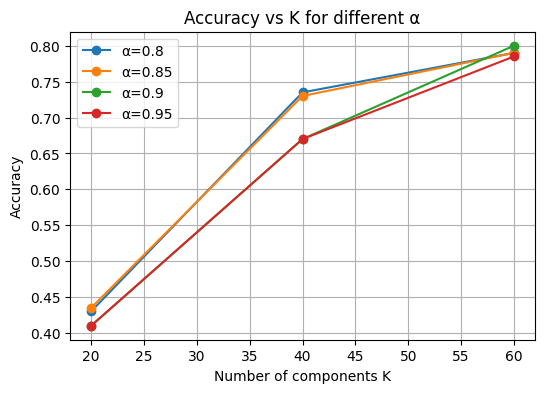

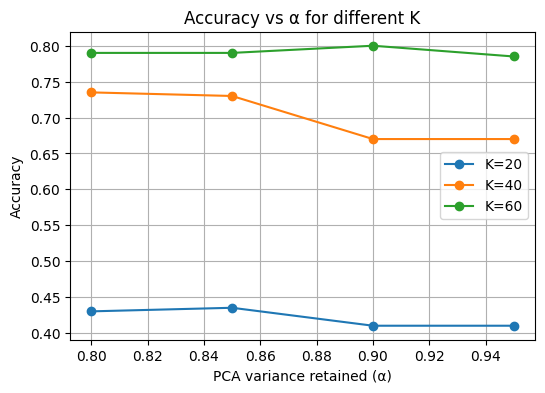


Accuracy (rows=alpha, cols=K):
K         20     40     60
alpha                     
0.80   0.430  0.735  0.790
0.85   0.435  0.730  0.790
0.90   0.410  0.670  0.800
0.95   0.410  0.670  0.785

F1-macro (rows=alpha, cols=K):
K            20        40        60
alpha                              
0.80   0.310741  0.683412  0.775702
0.85   0.305405  0.699064  0.774212
0.90   0.307468  0.627366  0.782752
0.95   0.277144  0.629113  0.771808


In [10]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import pandas as pd
from GMM import GMM 

alphas = [0.8, 0.85, 0.9, 0.95]
Ks = [20, 40, 60]

results = []
best_gmm = None
best_K = 0
best_alpha = 0
best_acc = 0
# Loop over each α and each K 
for alpha in alphas:
    X_train = pca_results[alpha]['X_train_pca']
    X_test = pca_results[alpha]['X_test_pca']
    
    for K in Ks:
        gmm = GMM(n_components=K, max_iter=100, tol=1e-4, random_state=42)
        gmm.fit(X_train)

        # hard‐assign each training point to a cluster
        train_clusters = gmm.perform_hard_prediction(X_train)

        # assign each cluster to the most frequent true label in that cluster 
        cluster_to_id = map_cluster_to_id(train_clusters, y_train, K)
        
        # training accuracy
        train_pred = np.array([cluster_to_id[c] for c in train_clusters])
        train_acc = accuracy_score(y_train, train_pred)

        # hard‐assign each test point to a cluster
        test_clusters = gmm.perform_hard_prediction(X_test)
        
        y_pred = np.array([cluster_to_id[c] for c in test_clusters])

        # testing accuracy and f1 score
        test_acc = accuracy_score(y_test, y_pred)
        f1  = f1_score(y_test, y_pred, average='macro')
        
        if test_acc > best_acc:
            best_acc = test_acc
            best_gmm = gmm
            best_K = K
            best_alpha = alpha

        # store results
        results.append({
            'alpha': alpha,
            'K': K,
            'accuracy': test_acc,
            'f1_macro': f1
        })
        print(f"α={alpha}, K={K} → training accuracy={train_acc:.3f} testing accuracy={test_acc:.3f}, f1={f1:.3f}")

# to dataframe 
df = pd.DataFrame(results)
pivot_acc = df.pivot(index='alpha', columns='K', values='accuracy')
pivot_f1  = df.pivot(index='alpha', columns='K', values='f1_macro')


# Accuracy vs K (one curve per α)
plt.figure(figsize=(6,4))
for alpha in alphas:
    plt.plot(Ks, pivot_acc.loc[alpha], marker='o', label=f'α={alpha}')
plt.xlabel('Number of components K')
plt.ylabel('Accuracy')
plt.title('Accuracy vs K for different α')
plt.legend()
plt.grid(True)

# Accuracy vs α (one curve per K)
plt.figure(figsize=(6,4))
for K in Ks:
    plt.plot(alphas, pivot_acc[K], marker='o', label=f'K={K}')
plt.xlabel('PCA variance retained (α)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs α for different K')
plt.legend()
plt.grid(True)


plt.show()

# results as table 
print("\nAccuracy (rows=alpha, cols=K):")
print(pivot_acc)
print("\nF1-macro (rows=alpha, cols=K):")
print(pivot_f1)

Best model: α=0.9, K=60 → testing accuracy=0.800, f1=0.783


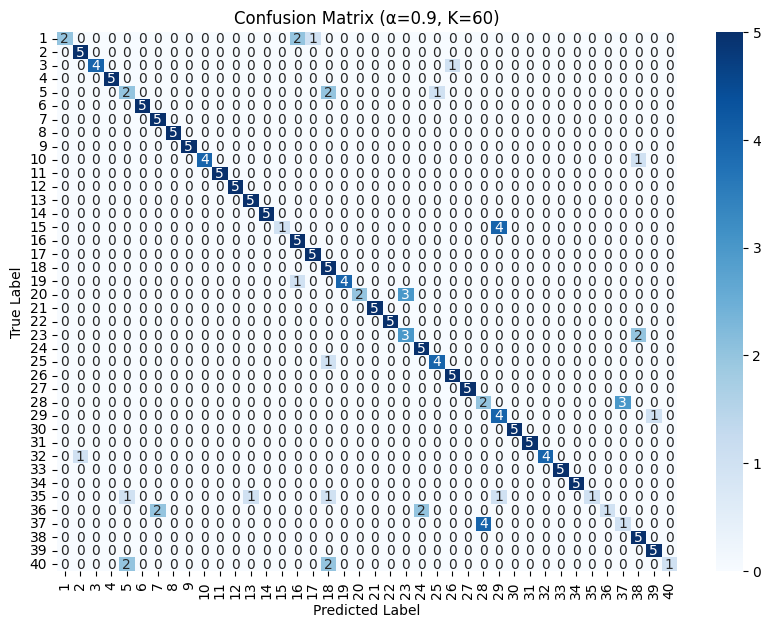

In [18]:
# Evaluate the best model on the test set
gmm_best_model = GMM(n_components=best_K, max_iter=100, tol=1e-4, random_state=42)
gmm_best_model.fit(pca_results[best_alpha]['X_train_pca'])
train_clusters = gmm_best_model.perform_hard_prediction(pca_results[best_alpha]['X_train_pca'])

# assign each cluster to the most frequent true label in that cluster
cluster_to_id = map_cluster_to_id(train_clusters, y_train, best_K)

# test clusters
test_clusters = gmm_best_model.perform_hard_prediction(pca_results[best_alpha]['X_test_pca'])
y_pred = np.array([cluster_to_id[c] for c in test_clusters])

test_acc = accuracy_score(y_test, y_pred)
f1  = f1_score(y_test, y_pred, average='macro')
print(f"Best model: α={best_alpha}, K={best_K} → testing accuracy={test_acc:.3f}, f1={f1:.3f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(1, 41), yticklabels=np.arange(1, 41))
plt.title(f"Confusion Matrix (α={best_alpha}, K={best_K})")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()